# Análise de formações táticas no campeonato brasileiro e suas influências no desempenho da equipe


In [1]:
#Import de bibliotecas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['yaxis.labellocation'] = 'top'

## Tratamento de Dados

Para trabalhar os dados do campeonato, é necessário realizar um refinamento e tratamento dos dados disponíveis. Os principais problemas notados na tabela são:

* Falta de dados de formação tática de 2003 até 2014
* Variável vencedor é uma string com o nome do time vitorioso.

### Falta de dados
Visando resolver a falta de dados, foram eliminados os dados destes anos, tendo em vista que não seriam de utilidade para a análise subsequente. Com isto, o banco de dados passou a contar com todas as partidas do campeonato brasileiro desde 2014 até 2021. Com isso, existe um efetivo total de 2670 partidas.

### Variável string

Para facilitar trabalhos futuros, a variável categórica 'vencedor' receberá uma nova classificação: $vencedor = [-1, 0, 1]$. Cada um dos valores tem um significado: Quando -1, houve empate, ninguém ganhou. Quando 0, vitória do visitante, e quando 1, vitória do mandante.




In [3]:
camp_full = pd.read_csv('./data/campeonato-brasileiro-full.csv')

camp_full.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor
0,1,1,2003-03-29,16:00,Sabado,Guarani,Vasco,NaN,NaN,NaN,NaN,Guarani,brinco de ouro,4,2,SP,RJ,SP
1,2,1,2003-03-29,16:00,Sabado,Athletico-PR,Gremio,NaN,NaN,NaN,NaN,Athletico-PR,arena da baixada,2,0,PR,RS,PR
2,3,1,2003-03-30,16:00,Domingo,Flamengo,Coritiba,NaN,NaN,NaN,NaN,-,maracana,1,1,RJ,PR,-
3,4,1,2003-03-30,16:00,Domingo,Goias,Paysandu,NaN,NaN,NaN,NaN,-,serra dourada,2,2,GO,PA,-
4,5,1,2003-03-30,16:00,Domingo,Internacional,Ponte Preta,NaN,NaN,NaN,NaN,-,beira rio,1,1,RS,SP,-


In [4]:
# Retirando colunas cujos dados sejam NaN
camp_full = camp_full.dropna()

#Convertendo dados de vitória para um vetor de valores: [-1, 0, 1] (empate, visitante, mandante)
camp_full.loc[camp_full['mandante'] == camp_full['vencedor'], 'vencedor'] = 1
camp_full.loc[camp_full['visitante'] == camp_full['vencedor'], 'vencedor'] = 0
camp_full.loc[camp_full['visitante_placar'] == camp_full['mandante_placar'], 'vencedor'] = -1



In [5]:
# Criando coluna SG_vencedor
camp_full.loc[camp_full['vencedor'] == -1, 'sg_vencedor'] = 0

camp_full.loc[camp_full['vencedor'] == 0, 'sg_vencedor'] = camp_full.loc[camp_full['vencedor'] == 0, 'visitante_placar'
                                                                         ] - camp_full.loc[camp_full['vencedor'] == 0, 'mandante_placar']

camp_full.loc[camp_full['vencedor'] == 1, 'sg_vencedor'] = camp_full.loc[camp_full['vencedor'] ==
                                                                         1]['mandante_placar'] - camp_full.loc[camp_full['vencedor'] == 1]['visitante_placar']


## Visualização de Dados
### Número de Utilização dos Esquemas táticos

Primeiramente, para começar a trabalhar, é interessante vizualizar os dados que estão sendo utilizados. Primeiramente, portanto, vizualizar-se-ão quais os esquemas táticos mais populares dentre os times mandantes e visitantes. 

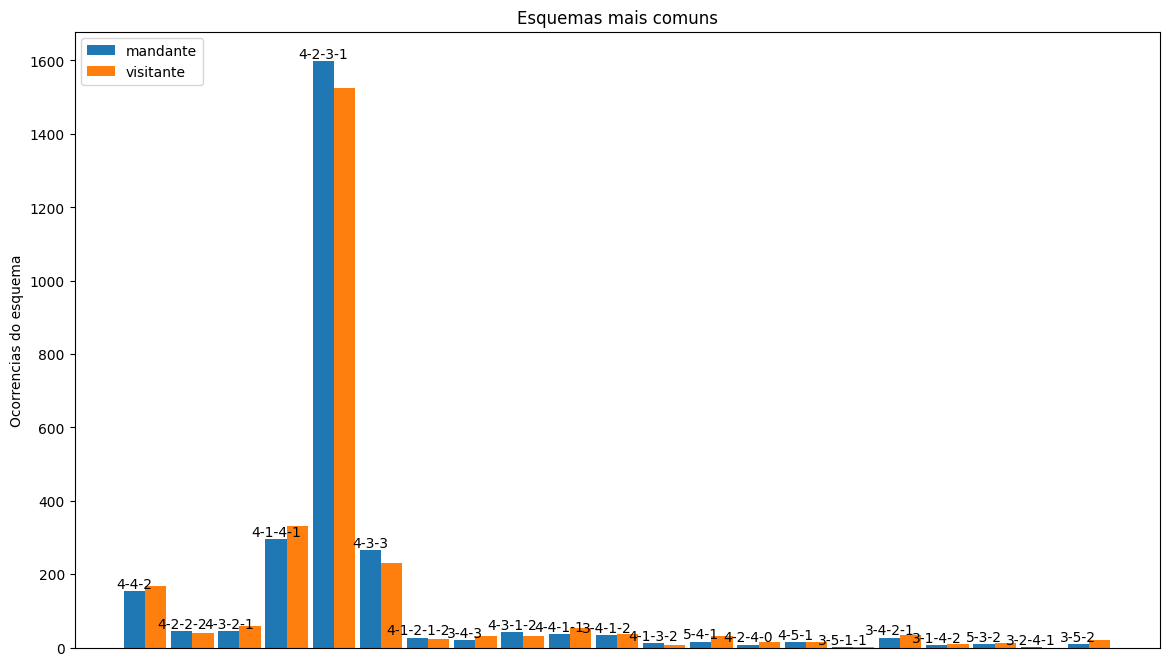

In [6]:
#  Separando as colunas que serão visualizadas
contagem_esquemas = camp_full['formacao_mandante']
ce_visitantes = camp_full['formacao_visitante']

# Contando número de esquemas utilizados
esquemas_unicos = contagem_esquemas.unique()

# Setando atributos do gráfico
fig, ax = plt.subplots()
ax.hist([contagem_esquemas, ce_visitantes], bins=len(esquemas_unicos), align='mid', rwidth=0.9, label=['mandante', 'visitante'])
ax.legend(loc='upper left')
ax.set_title('Esquemas mais comuns')
ax.set_ylabel('Ocorrencias do esquema', loc='center')
ax.xaxis.set_visible(False)

# Colocando etiquetas no gráfico
rects = ax.patches

for rect, label in zip(rects, esquemas_unicos):
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width() /2, height+0.01, label, ha='center', va='bottom')

# Plotando Gráfico
plt.show()

### Vitórias e Derrotas de Mandante por esquema tático (Número Absoluto)

Uma Abordagem inocente do problema se trataria de avaliar qual esquema tático possui melhor e pior desempenho. A métrica mais óbvia para tratar esta possibilidade é o número de derrotas utilizando um determinado esquema. Porém, certas falhas ficam mais que evidentes com esta abordagem:

* Um esquema que foi mais utilizado que os demais (no caso o esquema 4-2-3-1), logicamente, irá possuir um número absoluto de vitórias e derrotas muito maior que os outros.

* Existem diversos outros fatores relevantes, como a qualidade do time, que impactam no desempenho geral

Logo, fica evidente através de uma análise simplória dos gráficos e do que foi proposto acima, que esta métrica é extremamente pobre. Todavia, possibilita teorizar métricas um pouco mais afinadas que serão exploradas adiante.

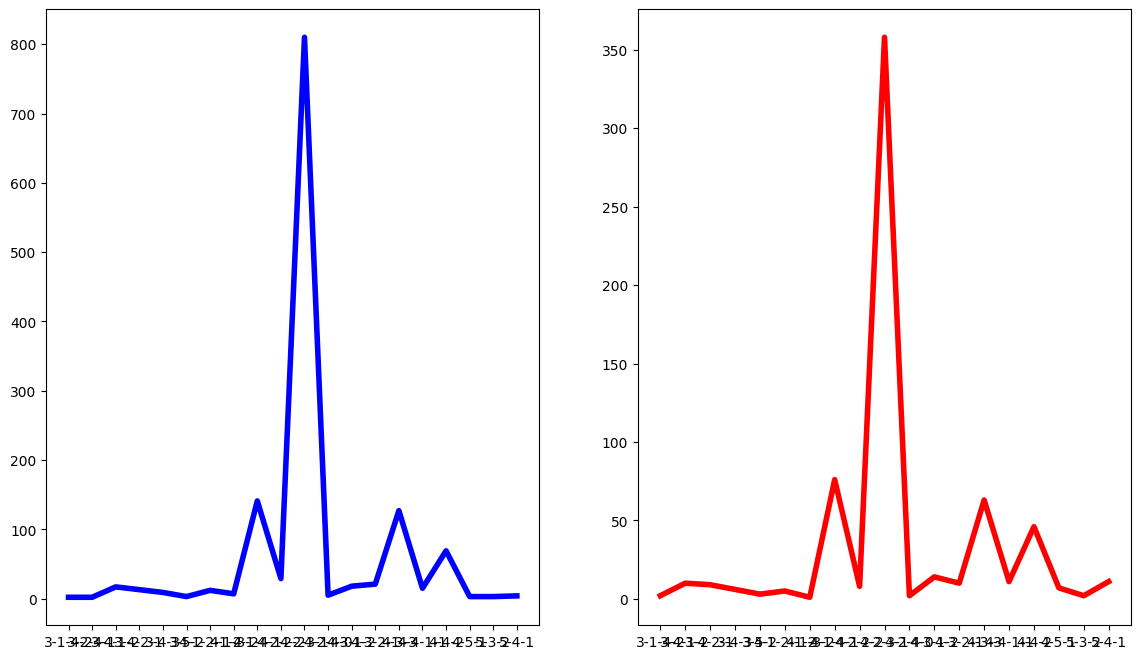

In [43]:
vitoria_esquema = camp_full.loc[camp_full['vencedor'] == 1]
vitoria_esquema = vitoria_esquema.groupby(['formacao_mandante'], as_index=False).size()

derrota =  camp_full.loc[camp_full['vencedor'] == 0]
derrota = derrota.groupby('formacao_mandante', as_index=False).size()

num_vit = vitoria_esquema['size']
esq = vitoria_esquema['formacao_mandante']

num_der = derrota['size']
esqder = derrota['formacao_mandante']

plt.subplot(1, 2, 1)
plt.plot(esq, num_vit, 'b-')

plt.subplot(1, 2, 2)
plt.plot(esqder, num_der, 'r-')
